In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as integrate
import time
from scipy.optimize import brentq
import math as math
import numpy.linalg as linalg
from scipy.interpolate import interp1d

Write a Monte Carlo simulation that generates scattering events following the distributions that you find analytically.

In [ ]:
'''The approach is to use different methods and see which one is the best for optimize the simulation.
We try with those methods:

1) Hit or Miss: This method involves generating random points within a defined rectangular area that 
encompasses the distribution curve of interest. Points beneath the curve (i.e., where the y-value of the 
point is less than the y-value of the distribution at that x) are kept ("hits"), while others are 
discarded ("misses"). The ratio of hits to total points gives an approximation of the area under the 
curve, which corresponds to the integral of the distribution. This technique is straightforward but can 
be inefficient, especially for narrow distributions.

2) Metropolis-Hastings: This method is a type of Markov Chain Monte Carlo (MCMC) technique
(stochastic process without memory, whose future state depends only on the present state and not on how 
it was reached). It generates a sequence of sample values in such a way that, as more samples are 
produced, the distribution of values more closely approximates the desired distribution. It does this by 
starting from an arbitrary position and generating a new sample (theta_star) based on a proposal 
distribution. This new sample is then accepted with a probability that depends on the ratio of the 
distribution's value at the new sample to that at the current sample. This method is more efficient than 
Hit or Miss for complex or multi-dimensional distributions.

3) Inverse Sampling: This method relies on the Cumulative Distribution Function (CDF) of the target 
distribution. By sampling from a uniform distribution and then applying the inverse CDF, samples are 
generated according to the desired distribution. This method requires the analytical form of the inverse 
CDF, which can be a limitation for distributions where the inverse CDF is difficult to calculate.'''

In [ ]:
#qui c'è la parte di tomas che per ora copio dall'altro progetto

In [2]:
# Physical costants
electron_charge = 1.602176634e-19 # C
speed_of_light = 299792458 # m/s
alpha = 0.007297
muon_mass = 0.105658374524 #GeV
electron_mass = 0.0005109989461 # GeV
E_exp=2*muon_mass + 0.005

conversion0 = 0.389379e6 #1/GeV --> nanoBarn
conversion1 = (5.34*10**(-19)) #Gev/c ---- > kg*m/s (momentum)
conversion2 = (1.78*10**(-27)) #Gev/c^2 -------> kg (mass)

# Functions
def total_cross_section_nb(s):
    return (((alpha**2)*np.pi*4/(3*s))*np.sqrt(1-(4*muon_mass**2/s))*(1+(2*muon_mass**2)/s))*conversion0

def differential_cross_section_nb(theta, s=E_exp**2): #rads
    return (((alpha**2)*np.pi*2/(4*s))*np.sqrt(1-(4*muon_mass**2/s))*((1+(4*muon_mass**2/s))+(1-(4*muon_mass**2/s))*np.cos(theta)**2))*conversion0

def pdf_theta(theta, s=E_exp**2): #rads!
    return np.sin(theta)*differential_cross_section_nb(theta, s)

print('Total cross section = ', total_cross_section_nb(E_exp**2))
cost_norm_theta = integrate.quad(lambda theta: pdf_theta(theta),0,np.pi)
print('Normalization pdf = ', cost_norm_theta[0])

def pdf_theta_norm(theta, s=E_exp**2):
    # Rescale both the integration interval and the pdf values
    return (1/cost_norm_theta[0])*pdf_theta((theta*np.pi/180), s)*np.pi/180 

print("Verify normalization: ", integrate.quad(lambda theta: pdf_theta_norm(theta),0,180)[0])

E=np.arange(2*muon_mass, E_exp + 0.1,0.0001) #CoM + 0.1 to show high energy behaviour
s=np.power(E,2)
angles=np.arange(0,180,1)
angles_rad=angles*(np.pi/180)
cos_angles=np.cos(angles_rad)

Total cross section =  586.0378845408211
Normalization pdf =  586.0378845408212
Verify normalization:  0.9999999999999999


In [3]:
N_simulated = 10**5

### > HIT or MISS

In [4]:
#Func
def hit_or_miss(distribution, num_samples, x_range, y_range):
    x_samples = np.random.uniform(*x_range, num_samples)
    y_samples = np.random.uniform(*y_range, num_samples)
    hits = y_samples <= distribution(x_samples)
    return x_samples[hits]

angle_range = (np.min(angles), np.max(angles))  # In degrees
pdf_range = (np.min(pdf_theta_norm(angles)), np.max(pdf_theta_norm(angles)))

In [5]:
#Data saving and performance of the method
file_time_HM = "data/time_HM_"+str(N_simulated)+".npy"
file_data_HM = "data/theta_samples_HM_"+str(N_simulated)+".npy"

start = time.time()
theta_samples_hm = hit_or_miss(pdf_theta_norm, N_simulated, angle_range, pdf_range)
end = time.time()

np.save(file_time_HM, round(end - start,3))
np.save(file_data_HM, theta_samples_hm)

time_HM = np.load(file_time_HM)
theta_samples_hm = np.load(file_data_HM)
accepted_hm = len(theta_samples_hm)/N_simulated

print("Execution time: ",time_HM, "sec for ",N_simulated, "iterations")
print("Accepted ratio:", accepted_hm)

Execution time:  0.033 sec for  100000 iterations
Accepted ratio: 0.64317


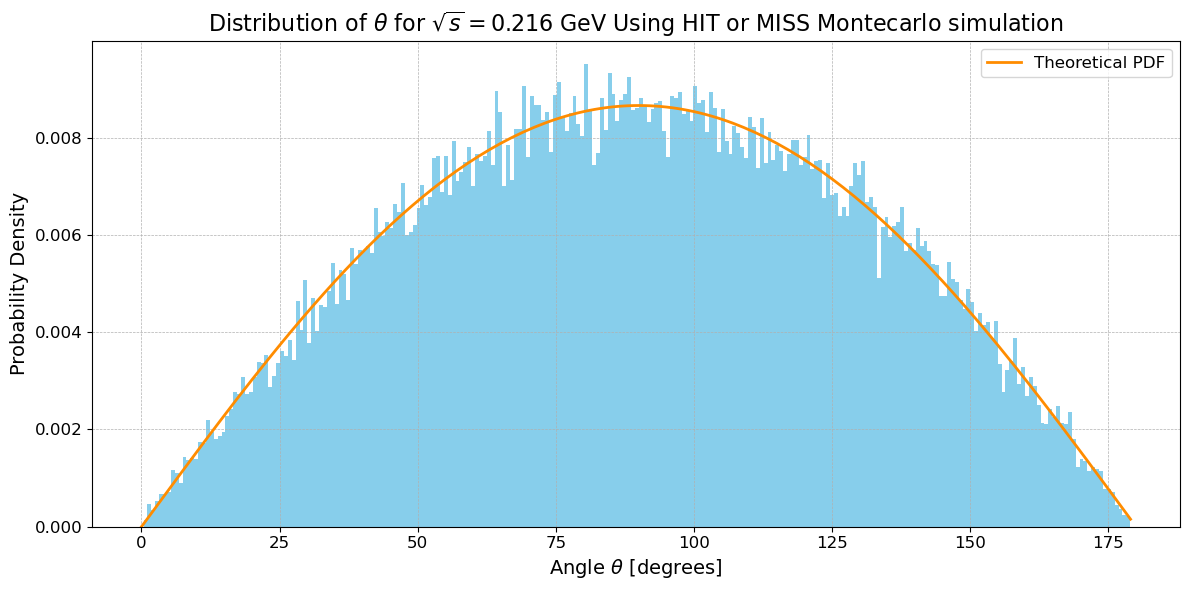

In [6]:
#Plot
num_bins_hm = int(np.sqrt(len(theta_samples_hm)))

plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(theta_samples_hm, bins=num_bins_hm, density=True, color='skyblue')
plt.plot(angles, pdf_theta_norm(angles), color='darkorange', linewidth=2, label="Theoretical PDF")
plt.title(r'Distribution of $\theta$ for $\sqrt{s}=$' + str(round(E_exp, 3)) + ' GeV Using HIT or MISS Montecarlo simulation', fontsize=16)
plt.xlabel(r'Angle $\theta$ [degrees]', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

### > METROPOLIS

In [7]:
#Func
def metropolis_hastings(distribution, initial_sample, iterations, passes):
    current_sample = initial_sample
    samples = [current_sample]
    for _ in range(iterations):
        new_sample = np.random.normal(current_sample, passes)
        acceptance_ratio = distribution(new_sample) / distribution(current_sample)
        if acceptance_ratio >= 1 or acceptance_ratio > np.random.random():
            current_sample = new_sample
        samples.append(current_sample)   
    return np.array(samples)

initial_sample = 90  # Start from the middle of the domain
passes = 5   # Determines how far we propose samples from current sample

In [8]:
#Data saving and performance of the method
file_time_MH = "data/time_MH_"+str(N_simulated)+".npy"  # Corrected
file_data_MH = "data/theta_samples_MH_"+str(N_simulated)+".npy"  # Corrected

theta_samples_mh = metropolis_hastings(pdf_theta_norm, initial_sample, N_simulated, passes)

np.save(file_time_MH, round(end - start,3))
np.save(file_data_MH, theta_samples_mh)

time_MH = np.load(file_time_MH)
theta_samples_mh = np.load(file_data_MH)
accepted_mh = len(theta_samples_mh)/N_simulated

print("Execution time: ",time_MH, "sec for ",N_simulated, "iterations")
print("Accepted ratio:", accepted_mh)

Execution time:  0.033 sec for  100000 iterations
Accepted ratio: 1.00001


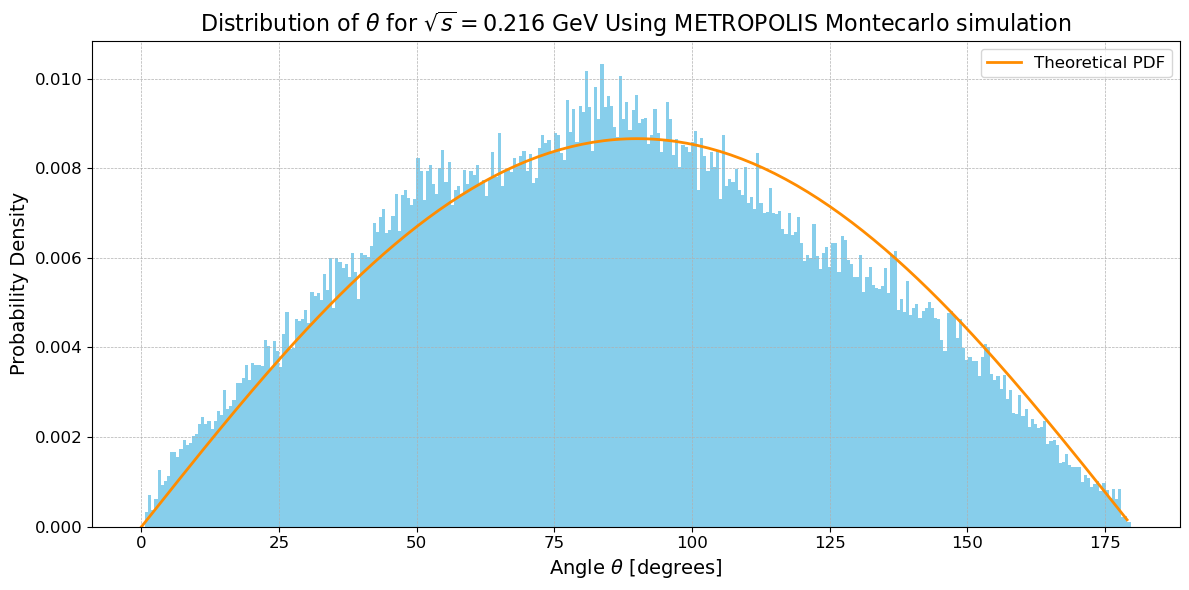

In [9]:
#Plot
num_bins_mh = int(np.sqrt(len(theta_samples_mh)))

plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(theta_samples_mh, bins=num_bins_mh, density=True, color='skyblue')
plt.plot(angles, pdf_theta_norm(angles), color='darkorange', linewidth=2, label="Theoretical PDF")
plt.title(r'Distribution of $\theta$ for $\sqrt{s}=$' + str(round(E_exp, 3)) + ' GeV Using METROPOLIS Montecarlo simulation', fontsize=16)
plt.xlabel(r'Angle $\theta$ [degrees]', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

### > INVERSE SAMPLING

In [10]:
#Func
def pdf_cos(z, s=E_exp**2):#- comes from sin(theta)d(theta) = -d(cos(theta))= -dz
    return(((alpha**2)*np.pi*2/(4*s))*np.sqrt(1-(4*muon_mass**2/s))*((1+(4*muon_mass**2/s))+(1-(4*muon_mass**2/s))*z**2))*0.389379e6

cost_norm_cos =integrate.quad(lambda z: pdf_cos(z),-1,1)

def pdf_cos_norm(z,s=E_exp**2):
    return pdf_cos(z,s)/cost_norm_z[0]

def cdf_zeros(y,x,s):
    cost = ((alpha**2)*np.pi*2/(4*s))*np.sqrt(1-(4*muon_mass**2/s))*conversion0
    norm_cost = total_cross_section_nb(s)
    return(- cost/(norm_cost))*( 1/3*(1-(4*muon_mass**2/s))*y**3 + \
                                (1+(4*muon_mass**2/s))*y - 4/3*(1 + 2*muon_mass**2/s) ) - x

In [11]:
#Data saving and performance of the method
file_time_IS = "data/time_IS_"+str(N_simulated)+".npy"  # Corrected
file_data_IS = "data/theta_samples_IS_"+str(N_simulated)+".npy"  # Corrected

x_samples = np.random.uniform(0,1,N_simulated)
theta_samples_is = [brentq((cdf_zeros),-1,1,args=(x,s)) for x,s in zip(x_samples,[E_exp**2]*N_simulated)]

np.save(file_time_IS, round(end - start,3))
np.save(file_data_IS, theta_samples_is)

time_IS = np.load(file_time_IS)
theta_samples_is = np.load(file_data_IS)
accepted_is = len((theta_samples_is))/N_simulated

print("Execution time: ",time_IS, "sec for ",N_simulated, "iterations")
print("Accepted ratio:", accepted_is)

Execution time:  0.033 sec for  100000 iterations
Accepted ratio: 1.0


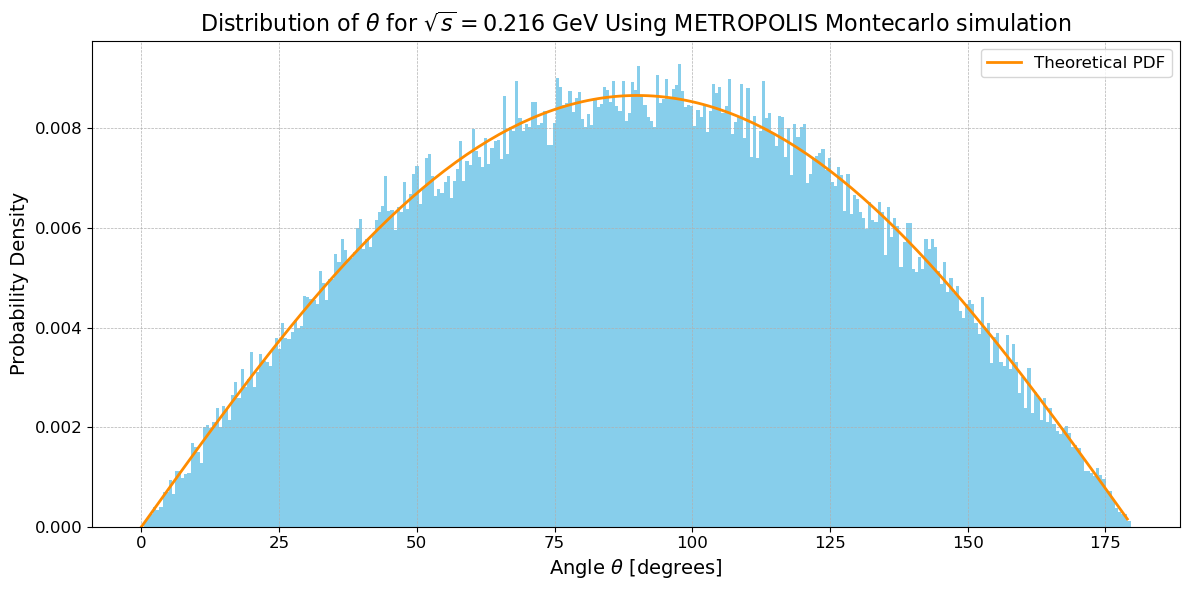

In [12]:
#Plot
num_bins_is = int(np.sqrt(len(theta_samples_is)))

plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(180*np.arccos(theta_samples_is)/np.pi, bins=num_bins_is, density=True, color='skyblue')
plt.plot(angles, pdf_theta_norm(angles), color='darkorange', linewidth=2, label="Theoretical PDF")
plt.title(r'Distribution of $\theta$ for $\sqrt{s}=$' + str(round(E_exp, 3)) + ' GeV Using METROPOLIS Montecarlo simulation', fontsize=16)
plt.xlabel(r'Angle $\theta$ [degrees]', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

[BabaYaga](https://www2.pv.infn.it/~hepcomplex/babayaga.html) is a Monte Carlo event generator for $e^+e^- --> e^+e^-, μ^+μ^-, γγ$ and $π^+π^-$ processes at flavour factories, i.e. for energies below 10-12 GeV, it has been developed at the INFN center of Pavia by  C.M. Carloni Calame, G. Montagna, O. Nicrosini, F. Piccinini.

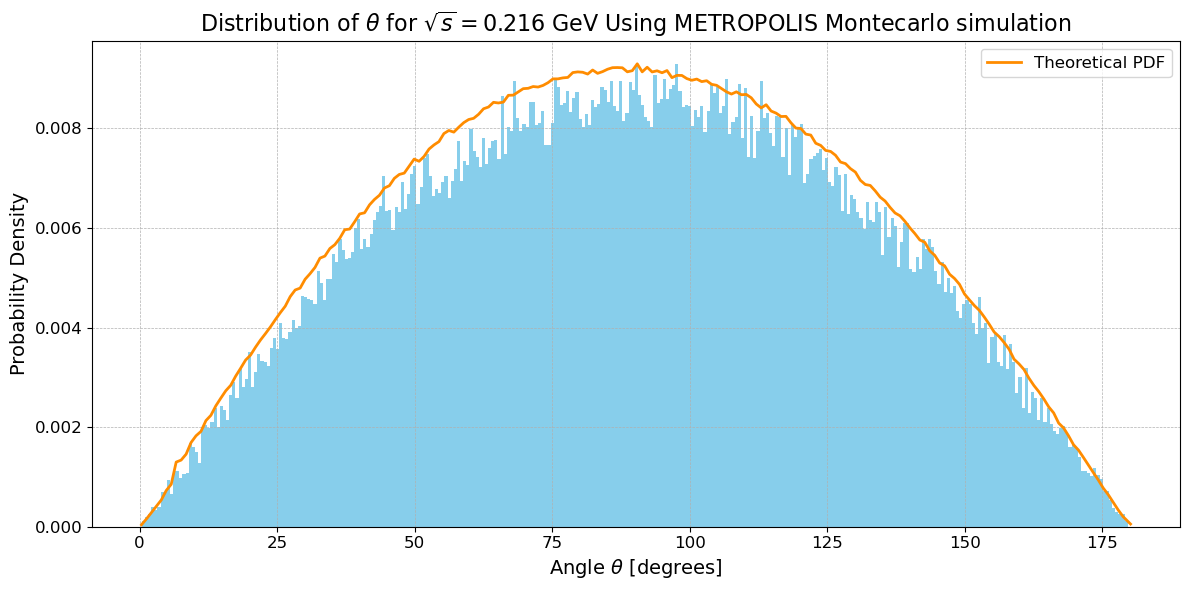

In [14]:
Babayaga = np.loadtxt("matched_el_th_exp_200.txt").T
theta_samples_compare = np.arccos(np.load(file_data_IS))*180/np.pi
num_bins_is = int(np.sqrt(len(theta_samples_compare)))

plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(theta_samples_compare, bins=num_bins_is, density=True, color='skyblue')
k=np.max(Babayaga[1])/np.max(counts)
centers = [Babayaga[0][i]+(Babayaga[0][i+1]-Babayaga[0][i])/2 for i in np.arange(0,len(Babayaga[0])-1)]
centers.append(Babayaga[0][-1]+(Babayaga[0][-1]-Babayaga[0][-2]))
plt.plot(centers,Babayaga[1]/k, color='darkorange', linewidth=2, label="Theoretical PDF")
plt.title(r'Distribution of $\theta$ for $\sqrt{s}=$' + str(round(E_exp, 3)) + ' GeV Using METROPOLIS Montecarlo simulation', fontsize=16)
plt.xlabel(r'Angle $\theta$ [degrees]', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

In [ ]:
saved_timeHM = np.load("data/time_HM_100000.npy")
saved_timeMH = np.load("data/time_MH_100000.npy")
saved_timeIS = np.load("data/time_IS_100000.npy")

methods = ["Hit or Miss", "Metropolis - Hastings", "Inverse sampling method"]
times = [saved_timeHM, saved_timeMH, saved_timeIS]
acceptances = [accepted_hm, accepted_mh, accepted_is]

for method, time, acceptance in zip(methods, times, acceptances):
    print(f"{method}: Time = {time}, Acceptance = {acceptance}")